**Содержание темы**

1. Практический ноутбук 1

2. [Практический ноутбук 2](https://colab.research.google.com/drive/1lkuUWExXbKCO7V6Rh40aM5EmPgjdcobe?usp=sharing)


**Инфо по выделенным ресурсам**

Данный служебный код помогает понять тип графической карты, подключенной к ноутбуку. 

Не забудьте уточнить, что среда выполнения в настройках колаба GPU или TPU. 


In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
process = psutil.Process(os.getpid())
print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
print("GPU Model: ", gpu.name)

Gen RAM Free: 12.8 GB  | Proc size: 118.2 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB
GPU Model:  Tesla P100-PCIE-16GB


In [ ]:
# Загрузка библиотек

# Пандас
import pandas as pd 

# Numpy
import numpy as np 

# random
import random

# из tensorflow
# оптимайзер для обучения нс
from tensorflow.keras.optimizers import Adam

# Два варианта сборки моделей
from tensorflow.keras.models import Sequential, Model 

# Стандартные слои моделей нс
from tensorflow.keras.layers import concatenate, Reshape, Input, Dense, Dropout, Conv1D, LSTM, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization, Flatten, GlobalAveragePooling1D, Activation, GlobalMaxPooling1D

# функция ошибки для обучения нс
from tensorflow.keras.losses import MAE

# для отрисовки дерева слоев нс
from tensorflow.keras.utils import plot_model

# Нормировщики данных
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

# Для генерации выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt 

# для загрузки данных по ссылке
import gdown

# модуль подсчета времени
import time

## Подбор архитектуры свёрточной сети

## Задача: Предсказание стоимости акций Лукойла

В лекции УИИ по обработтке временых рядов использовались акции Сбербанка. Попробуем с помощью генетических алгоритм найти архитектуру нейронной сети, которая как можно лучше будет прогнозировать значени акции на один шаг на основе знаний о стоимости акций на определенном количестве шагов до этого момента.

###Загрузка данных

Код по загрузке данных для поиска архитектуры нейронной сети аналогичен коду в лекции

"Базовый блок | Обработка временных рядов с помощью нейронных сетей (Практика 2) | УИИ"

Загрузим данные акций за 16-17 года и 18-19 года:

In [ ]:
# Загрузка датасетов из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/16_17.csv', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/18_19.csv', None, quiet=True)

'18_19.csv'

Переведем данные в DataFrame:

In [ ]:
# Чтение данных в таблицу pandas
base_data = pd.read_csv('16_17.csv', sep=';')

Посмотрим содержимое таблицы и выведем пример нулевой строки:

In [ ]:
# Вывод первых строк таблицы
base_data.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,04.01.2016,10:00:00,2351.0,2355.8,2350.0,2350.0,2547
1,04.01.2016,10:01:00,2352.9,2355.7,2350.0,2355.7,195
2,04.01.2016,10:02:00,2355.6,2356.0,2351.4,2354.1,257
3,04.01.2016,10:03:00,2354.5,2355.0,2351.2,2353.7,763
4,04.01.2016,10:04:00,2353.1,2353.9,2353.1,2353.6,231


какждая строка соответсвует минутному отрезку

In [ ]:
base_data.shape

(263925, 7)

Изучив содержимое таблиц, снова их подгрузим, но уже сразу удалим ненужные столбцы по дате и времени:

In [ ]:
# Пример данных из нулевой строки
print(base_data.values[0])

['04.01.2016' '10:00:00' 2351.0 2355.8 2350.0 2350.0 2547]


In [ ]:
# Чтение данных в таблицы с удалением ненужных столбцов
data16_17 = pd.read_csv('16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])
data18_19 = pd.read_csv('18_19.csv', sep=';').drop(columns=['DATE', 'TIME'])

# Проверка формы данных
print(data16_17.shape) 
print(data18_19.shape) 

(263925, 5)
(217947, 5)


In [ ]:
# Пример данных одного датасета
d = data18_19

print(d.shape[0])                         # Всего записей (строк)
print(d.shape[1])                         # Количество столбцов
print(d.iloc[0])                          # Пример нулевой строки данных

217947
5
OPEN      3341.0
MAX       3356.0
MIN       3340.0
CLOSE     3355.0
VOLUME    6088.0
Name: 0, dtype: float64


Объединим таблицы в одну общую:

Тут мы отойдем от кода лекции и изменим размер используемых данных. Нам предстоит проводить множество экспериментов по поиску нейронной сети и слишком большой объем данных сильно замедлит поиск. 

Мы возьмем в изучение строки по акциям каждые 1 минут, указав `[::15]` при формировании объединенного датафрейма  

In [ ]:
# Создание общего набора данных из двух датасетов
data = pd.concat([data16_17, data18_19]).iloc[::15].to_numpy()

Посмотрим размерность новой таблицы:

In [ ]:
print(data.shape) 

(32125, 5)


Создадим словарь из названия столбцов и выведем его на экран:

In [ ]:
# Задание текстовых меток каналов данных (столбцов)
CHANNEL_NAMES = ['Open', 'Max', 'Min', 'Close', 'Volume']

# Получение словаря с именами и индексами каналов данных
CHANNEL_INDEX = {name: chan for chan, name in enumerate(CHANNEL_NAMES)}
print(CHANNEL_INDEX)

{'Open': 0, 'Max': 1, 'Min': 2, 'Close': 3, 'Volume': 4}


###Иллюстрация данных в графическом виде

Выведем данные для дальнейшей работы. Данные будут отображаться с позиции с номером `start`, длиной `length` отчетов. Отрисуем четыре линии со значениями OPEN, MIN, MAX, CLOSE и гистограммы по объему продаж:


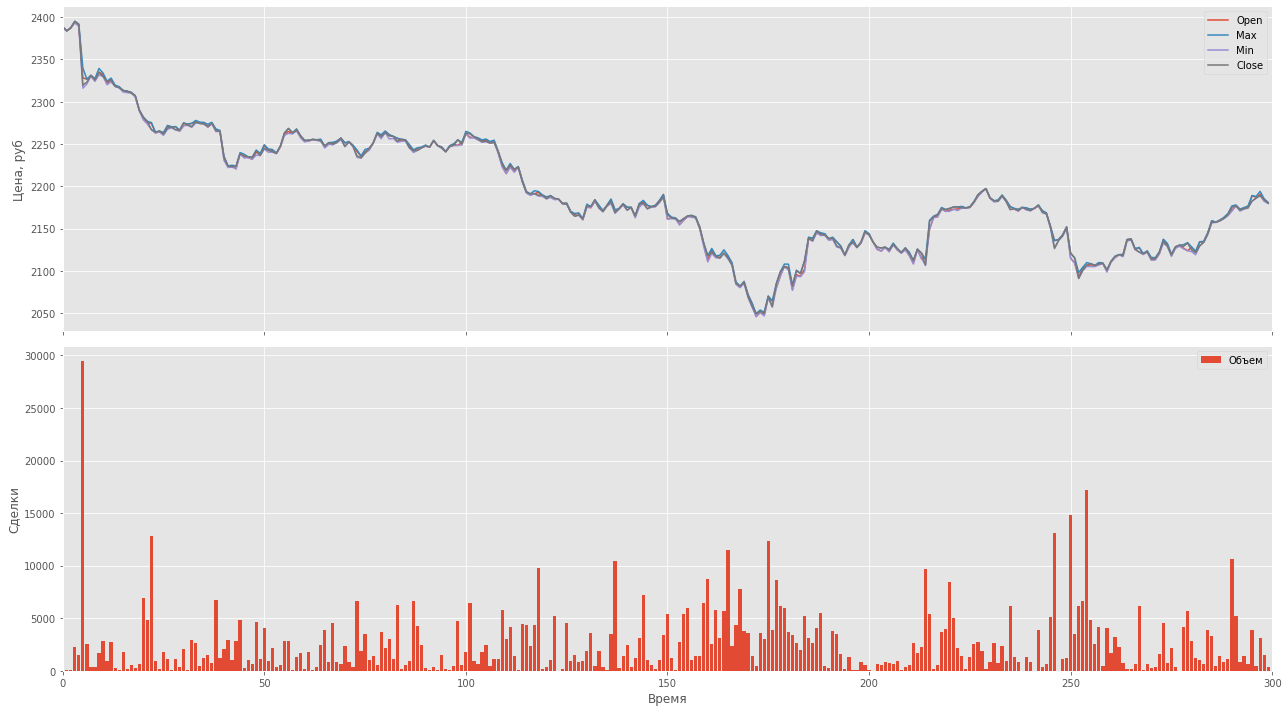

In [ ]:
# Отображение исходных данных от точки start и длиной length
start = 100
length = 300

# Задание полотна для графиков - два подграфика один под другим с общей осью x
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

# Четыре основных канала - open, max, min, close
for chn in range(4):
    # Отрисовка одного канала данных
    # От начальной точки start длиной length
    ax1.plot(data[start:start + length, chn],
             label=CHANNEL_NAMES[chn])
ax1.set_ylabel('Цена, руб')
ax1.legend()

# Канал volume (объем)
ax2.bar(x=np.arange(length), 
        height=data[start:start + length, CHANNEL_INDEX['Volume']],
        label='Объем')
ax2.set_ylabel('Сделки')
ax2.legend()

plt.xlabel('Время')
# Регулировка пределов оси x
plt.xlim(0, length)
# Указание расположить подграфики плотнее друг к другу
plt.tight_layout()
# Фиксация графика
plt.show()

### Подготовка выборок данных для нейросети




In [ ]:
# Словарь каналов данных с их индексами
print(CHANNEL_INDEX)

{'Open': 0, 'Max': 1, 'Min': 2, 'Close': 3, 'Volume': 4}


Установим гиперпараметры, отберем входные и выходные параметры. 300 отчетов, 30 тысяч примеров пойдут в проверочную выборку:

In [ ]:
# Задание гиперпараметров
CHANNEL_X = CHANNEL_NAMES                 # Отбор каналов входных данных
CHANNEL_Y = ['Close']                     # Отбор каналов данных для предсказания
SEQ_LEN = 300                             # Длина прошедших данных для анализа
BATCH_SIZE = 32                           # Объем батча для генератора
TEST_LEN = 3000                          # Объем тестовой выборки
TRAIN_LEN = data.shape[0] - TEST_LEN      # Объем обучающей выборки

Определим, какие данные пойдут в выборки. Разделим основной набор данных на обучающую и тестовую выборки. Обязательно нормируем данные. То же самое сделаем с выходными данными. При помощи генератора создадим выборки для обучения и проверки:

In [ ]:
# Формирование списков индексов каналов данных для входных и выходных выборок
chn_x = [CHANNEL_INDEX[c] for c in CHANNEL_X]
chn_y = [CHANNEL_INDEX[c] for c in CHANNEL_Y]

# Проверка результата
print(chn_x, chn_y)

# Разделение данных на тренировочный и тестовый наборы
# 2*SEQ_LEN - для разрыва между тренировочными и тестовыми данными 
# варьируемый параметр, страховка от пересечения
data_train, data_test = data[:TRAIN_LEN], data[TRAIN_LEN + 2*SEQ_LEN:]

# Отбор входных данных
x_data_train, x_data_test = data_train[:, chn_x], data_test[:, chn_x]

# Масштабирование данных
x_scaler = MinMaxScaler()
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

# Отбор выходных данных
y_data_train, y_data_test = data_train[:, chn_y], data_test[:, chn_y]

# Масштабирование данных
y_scaler = MinMaxScaler()
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)

# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')

# Создание генератора для обучения
train_datagen = TimeseriesGenerator(x_data_train, 
                                    y_data_train,
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)

# Аналогичный генератор для валидации при обучении
val_datagen = TimeseriesGenerator(x_data_test, 
                                  y_data_test,
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

# Проверка формы выдаваемого генератором результата
print(f'Train batch x: {train_datagen[0][0].shape}, y: {train_datagen[0][1].shape}')

[0, 1, 2, 3, 4] [3]
Train data: (29125, 5), (29125, 1)
Test  data: (2400, 5), (2400, 1)
Train batch x: (32, 300, 5), y: (32, 1)


In [ ]:
inputShape = train_datagen[0][0].shape
print(inputShape)
outputShape = train_datagen[0][1].shape
print(outputShape)

(32, 300, 5)
(32, 1)


Не забудем про тестовую выборку. Также при помощи генератора сформируем окончательные тестовые выборки:

In [ ]:
# Генератор тестовой выборки, генерирует один батч на всю выборку
test_datagen = TimeseriesGenerator(x_data_test, 
                                   y_data_test,
                                   length=SEQ_LEN,
                                   stride=1,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

# Формирование тестовой выборки из генератора
x_test, y_test = test_datagen[0]

# Проверка формы тестовой выборки
print(f'Test x: {x_test.shape}, y: {y_test.shape}')

Test x: (2100, 300, 5), y: (2100, 1)


### Сервисные функции

также из лекции "Базовый блок | Обработка временных рядов с помощью нейронных сетей (Практика 1) | УИИ"

Вспомним эти сервисные функции, которые упростят дальнейшие эксперименты с архитектурами НС:
- `get_pred()` – обученная модель. Предсказывает результат, который возвращается к ненормированным данным;
- `correlate()` – расчет коэффициента автокорреляции;
- `show_predict()` – построение графиков предсказания и верных ответов;
- `auto_corr()` – расчет и построение графика автокорреляции;

In [ ]:
def get_pred(currModel, 
             xVal, 
             yVal, 
             yScaler):
  '''
  Функция рассчитываем результаты прогнозирования сети
  В аргументы принимает сеть (currModel) и проверочную выборку
  Выдаёт результаты предсказания predVal
  И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
  '''
  
  # Вычисление и деномализация предсказания
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  
  # Денормализация верных ответов
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  # И возвращаем исходны масштаб данных, до нормализации
  return (predVal, yValUnscaled)


# Функция расёта корреляции дух одномерных векторов

def correlate(a, 
              b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val # аналог функции в нампи np.corrcoef(a, b)[0, 1]


def show_predict(start, 
                 step, 
                 channel, 
                 predVal, 
                 yValUnscaled):
  '''
  Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
  start - точка с которой начинаем отрисовку графика
  step - длина графика, которую отрисовываем
  channel - какой канал отрисовываем
  '''
  
  plt.figure(figsize=(12, 5))
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  


def auto_corr(channels, corrSteps, predVal, yValUnscaled, plot_graf = True, return_data = False):
  '''
  Функция рисуем корреляцию прогнозированного сигнала с правильным
  Смещая на различное количество шагов назад
  Для проверки появления эффекта автокорреляции
  channels - по каким каналам отображать корреляцию
  corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
  showGraf - показываем график или нет
  returnData - возвращаем массивы автокорреляции или нет
  '''
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    if plot_graf: #Если нужно показать график
      plt.figure(figsize=(12, 5))
      plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')

  if plot_graf: #Если нужно показать график
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

  if return_data: #Если нужно вернуть массивы автокорреляции
     return corr, own_corr

## Подбор линейной архитектуры

В данном разделе мы будем искать оптимальный состав линейной нейросети

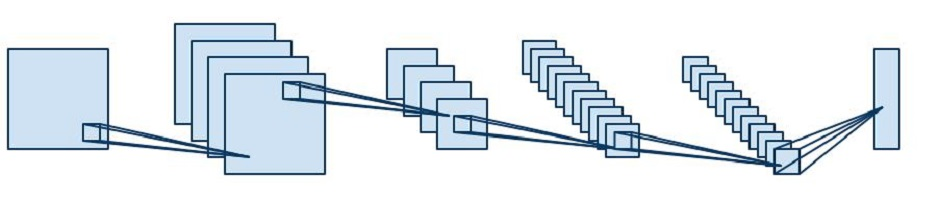

В задачу генетического алгоритма зачастую ставится задача найти оптимальные параметры из конечного набора. Поэтому часто применяемой практикой является изначальное построение готовой сети  со множеством слоеа и далее уже поиск и устранение лишних слоев и настройка оптимальных значений оставшихся слоев.

----
**То есть за основу берется некая гипотеза построения сети и далее она оттачивается генетикой**

 Будем искать сеть со следующей логикой построения:
 
 **Входной блок**

*   0 - делаем ли нормализацию
*   1 - размер первого свёрточного слоя
*   2 - ядро первого свёрточного слоя 
*   3 - функция активации первого слоя
*   4 - делаем ли MaxPooling0
*   5 - размер MaxPooling0

**Первый скрытый блок**

*   6 - Делаем ли второй сверточный слой
*   7 - размер второго сверточного слоя
*   8 - ядро второго сверточного слоя
*   9 - делаем ли MaxPooling1
*   10 - размер MaxPooling1
*   11 - функция активации

**Второй скрытый блок**

*   12 - Делаем ли третий сверточный слой
*   13 - размер третьего сверточного слоя
*   14 - ядро третьего сверточного слоя
*   15 - делаем ли MaxPooling2
*   16 - размер MaxPooling2
*   17 - функция активации 

----
**Третий скрытый блок Dense до Flatten()**
*   18 - Делаем ли дополнительный полносвязного слой
*   19 - размер полносвязного слоя
*   20 - функция активации дополнительного слоя
----

**Предпоследний скрытый слой**

*   21 - функция активации предпоследнего слоя
*   23 - делаем ли нормализацию 

**Выходной слой**

*   22 - функция активации выходного слоя
*   24 - размер полносвязного слоя

## Функция формирования модели из бота

Реализуем вышеуказанную логику в функции, которая будет собирать модель на основе значений прихдящих в нее в виде бота, являющегося списком значений

Кроме того применим еще пару идей:
- проверим идею стоит поставить дополнительный полносвязный слой до вытягивания значений в вектор или передовать данные сразу со сверточного блока
- для формирования значений размера свертки и количества нейронов будем использывать степень `2`. То есть будем искать значение в степень которого мы возведем двойку. 
- применим ход, который помогает обходить проблему памяти, возникающую иногда при применении слоя `Flatten()`, а далее полносвязного слоя. Мы сделаем условие, что при превышению размера слоя добавленного до `Flatten()` контрольного значения, будет применен иной вытягивающий слой `GlobalAveragePooling1D()`

In [ ]:
#Создаём сеть (net - список параметров)
def create_randnet(net, xLen, channels, num_cls, control_level_shape = 10**5):
  '''
  net - полученный бот со списком значений для формирования сети
  xLen - размер анализируемых данных до предсказания
  channels - количество каналов данных
  num_cls - количество предсказываемых шагов
  control_level_shape - парамметр при превышению которого будет применен 
                        слой GlobalAveragePooling1D, а не Flatten
  '''
  

  model = Sequential()             # Создаем моель Sequential

  '''
  Присвоение значений параметрам слоев из значений полученного бота
 
  Входной блок
  '''
  makeFirstNormalization = net[0]  # Делаем ли нормализацию в начале
  firstConvSize = 2 ** net[1]      # Размер первого вёрточного слоя
  firstConvKernel = net[2]         # Ядро первого свёрточного слоя
  activation0 = net[3]             # Функция активации входного слоя
  makeMaxPooling0 = net[4]         # Делаем ли maxpooling для нулевого слоя
  maxPoolingSize0 = net[5]         # Размер MaxPooling

  '''
  Первый скрытый Conv блок
  '''
  makeSecondConv = net[6]          # Делаем ли второй свёрточный слой
  secondConvSize = 2 ** net[7]     # Размер второго свёрточного слоя
  secondConvKernel = net[8]        # Ядро второго свёрточного слоя
  makeMaxPooling1 = net[9]         # Делаем ли MaxPooling
  maxPoolingSize1 = net[10]        # Размер MaxPooling
  activation1 = net[11]            # Функция активации

  '''
  Второй скрытый Conv блок
  '''
  makeThirdConv = net[12]          # Делаем ли второй свёрточный слой
  thirdConvSize = 2 ** net[13]     # Размер второго свёрточного слоя
  thirdConvKernel = net[14]        # Ядро второго свёрточного слоя
  makeMaxPooling2 = net[15]        # Делаем ли MaxPooling
  maxPoolingSize2 = net[16]        # Размер MaxPooling
  activation2 = net[17]            # Функция активации

  '''
  Третий скрытый dense блок
  '''
  makeDense = net[18]              # Делаем ли Dense до Flatten 
  denseSize0 = 2 ** net[19]        # Размер полносвязного слоя 
  activationdense0 = net[20]       # Функция активации

  '''
  Выходной dense блок
  '''
  denseSize1 = 2 ** net[21]        # Размер предпоследнего полносвязного слоя 
  activationdense1 = net[22]       # Функция активации предпоследнего полносвязного слоя 
  makeSecondNormalization = net[23]  # Делаем ли нормализацию в начале
  activationdense2 = net[24]       # Функция активации дпоследнего полносвязного слоя 

  '''
  Список активационных функций
  '''
  activation_list = ['linear','relu', 'elu', 'selu' ,'tanh'] 


  '''
  Условия для формирования блоков
  _______________________________

  Входной Conv блок
  '''
  # Если делаем нормализацию в начале
  if (makeFirstNormalization):      
      # Добавляем слой BatchNormalization
      model.add(BatchNormalization(input_shape=(xLen, channels))) 

      # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
      model.add(Conv1D(firstConvSize, firstConvKernel,
      activation=activation_list[activation0], padding='same')) 

  else:
      # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
      model.add(Conv1D(firstConvSize, firstConvKernel, input_shape=(xLen, channels),
                      activation=activation_list[activation0], padding='same')) 
      # Если делаем maxpooling
  if makeMaxPooling0:               
      model.add(MaxPooling1D(maxPoolingSize0))

  '''
  Первый скрытый Conv блок
  '''
  # Если делаем второй свёрточный слой
  if (makeSecondConv):              
      # Добавляем Conv1D-слой с secondConvSize нейронами и ядром (secondConvKernel)
      model.add(Conv1D(secondConvSize, secondConvKernel,
                      activation=activation_list[activation1], padding='same')) 
      
      # Если делаем MaxPooling
      if (makeMaxPooling1):           
        # Добавляем слой MaxPooling1D с размером (maxPoolingSize)
        model.add(MaxPooling1D(pool_size=maxPoolingSize1)) 

  '''
  Второй скрытый Conv блок
  '''
  # Если делаем второй свёрточный слой
  if (makeThirdConv):               
      # Добавляем Conv1D-слой с secondConvSize нейронами и ядром (secondConvKernel)
      model.add(Conv1D(thirdConvSize, thirdConvKernel,
                      activation=activation_list[activation2], padding='same')) 
      # Если делаем MaxPooling
      if (makeMaxPooling2):           
          # Добавляем слой MaxPooling1D с размером (maxPoolingSize, maxPoolingSize)
          model.add(MaxPooling1D(pool_size=maxPoolingSize2)) 

  '''
  Третий скрытый dense блок
  '''
  # Если делаем Dense до Flatten() или GlobalAveragePooling1D()
  if (makeDense):
      model.add(Dense(denseSize0, activation=activation_list[activationdense0]))

  '''
  Блок проверки размерности слоя
  Для применения Flatten() или GlobalAveragePooling1D()
  для вытягивания в вектор значений и передачи в выходной блок из Dense слоев
  '''
  # Получаем размерность последнего из добавленных слоев
  control_shape = model.layers[-1].output.get_shape()

  # Сравниваем с контрольным значением и применяем слой по условию
  if control_shape[-1]*control_shape[-2] < control_level_shape:
      model.add(Flatten())                   # Добавляем слой Flatten
  else: model.add(GlobalAveragePooling1D())  # Добавляем слой GlobalAveragePooling1D
 
  '''
  Выходной dense блок
  '''
  # Если делаем финальную нормализацию         
  if (makeSecondNormalization):     
      model.add(BatchNormalization()) # Добавляем слой BatchNormalization
  # Добавляем слой Dense с denseSize нейронами  
  model.add(Dense(denseSize1, activation=activation_list[activationdense1])) 
  # Добавляем Dense-слой с softmax-активацией и 10 нейронами
  model.add(Dense(num_cls, activation=activation_list[activationdense2]))   
  
  # Возвращаем модель
  return model    

## Функция формирования случайного бота

Теперь нам нужна функция которая будет формировать список со случайными значениями, это случайных ботов популяции.

Так как каждое значение списка ответственно за определенную часть будущей модели, то диапозон значений в которых будет создаваться случайное значение должно четко соответствовать его будущей задаче!

Данную задачу можно реализовать через создания пустого списа и почередного добавления методом `append()` очередного случайного значения нужно типа и в диапозоне связанным с пааметром. 

Например:
- для формирования значений нейронов от 4 до 1024, нужно искать случайное значение степени двойки от 2 до 10 в виде `random.randint(2,10)`
- если нам нужен тригер "сделать/не сделать" слой, то это можно реализовать через значения 0 и 1, как `random.randint(0,1)`

- если мы выбираем активационную функцию, то мы можем искать случайное значение индекса списка активационных функций

Важно! Последовательность добавления значений в список бота, должна четко соответсовать порядку применения его значений в функции формирования сети. 

In [ ]:
def create_bot4net():
  '''
  Функция создания списка случайных параметров
  '''

  net = []
  '''
  Входной Conv блок
  '''
  net.append(random.randint(0,1)) # 0 Делаем или нет нормализацию 
  net.append(random.randint(3,10)) # 1 Первый свёрточный слой от 4 до 1024 
  net.append(random.randint(2,5)) # 2 Ядро первого свёрточного слоя от 2 до 7
  net.append(random.randint(0,4)) # 3 Функция активации первого слоя
  net.append(random.randint(0,1)) # 4 Делаем ли MaxPooling
  net.append(random.randint(1,4)) # 5 Размер MaxPooling

  '''
  Первый скрытый Conv блок
  '''
  net.append(random.randint(0,1)) # 6 Сколько делаем еще сверточных слоев
  net.append(random.randint(3,10)) # 1 Первый свёрточный слой от 4 до 1024 
  net.append(random.randint(2,5)) # 8 Ядро второго свёрточного слоя от 2 до 8
  net.append(random.randint(0,1)) # 9 Делаем ли MaxPooling
  net.append(random.randint(1,4)) # 10 Размер MaxPooling
  net.append(random.randint(0,4)) # 11 Функция активации второго слоя

  '''
  Второй скрытый Conv блок
  '''
  net.append(random.randint(0,1)) # 12 Сколько делаем еще сверточных слоев
  net.append(random.randint(3,10)) # 1 Первый свёрточный слой от 4 до 1024 
  net.append(random.randint(2,5)) # 14 Ядро второго свёрточного слоя от 2 до 8
  net.append(random.randint(0,1)) # 14 Делаем ли MaxPooling
  net.append(random.randint(1,4)) # 16 Размер MaxPooling
  net.append(random.randint(0,4)) # 17 Функция активации второго слоя

  '''
  Третий скрытый dense блок
  '''
  net.append(random.randint(0,1)) # 18 Делаем ли Dense до Flatten 
  net.append(random.randint(2,10)) # 19 Размер полносвязного слоя 
  net.append(random.randint(0,4)) # 20 Функция активации

  '''
  Выходной dense блок
  '''
  net.append(random.randint(2,10)) # 21 Размер полносвязного слоя от 4 до 1024
  net.append(random.randint(0,4)) # 22 Функция активации предпоследнего dense слоя
  net.append(random.randint(0,1)) # 23 Делаем ли финальную нормализацию слой
  net.append(random.randint(0,4)) # 24 Функция активации последнего слоя
  
  return net

Создадим случаного бота функцией `create_bot4net()` и подадим в функцию формирования сети из бота - `create_randnet()`

In [ ]:
bot = create_bot4net()
print(bot)
print('Длина бота', len(bot))
model = create_randnet(bot,
                      inputShape[1], # количество подаваемых шагов в наборе
                      inputShape[2], # количество каналов данных в наборе
                      outputShape[1] # на сколько предсказываем 
                      )
# выводим слои модели 
model.summary()                               

[1, 5, 5, 1, 0, 2, 1, 4, 2, 0, 3, 4, 1, 7, 2, 1, 2, 4, 1, 2, 0, 10, 0, 1, 4]
Длина бота 25
Model: "sequential_304"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_291 (Bat (None, 300, 5)            20        
_________________________________________________________________
conv1d_684 (Conv1D)          (None, 300, 32)           832       
_________________________________________________________________
conv1d_685 (Conv1D)          (None, 300, 16)           1040      
_________________________________________________________________
conv1d_686 (Conv1D)          (None, 300, 128)          4224      
_________________________________________________________________
max_pooling1d_330 (MaxPoolin (None, 150, 128)          0         
_________________________________________________________________
dense_725 (Dense)            (None, 150, 4)            516       
___________________________

## Функция оценки бота

Как и в прошлых задачах по генетическому отбору - нужно сформировать функцию оценки работы бота по значению которой бы будем сортировать нужным образом ботов для поиска лучших.

В задаче предсказания следущего шага на основе определенного количества `xLen` предыдущих, кроме самой точности предсказания важно оценивать и наличие корреляции автокорреляции.

Это сложная задача, так как надо искать и по точности предсказания и по отсутсвию корреляции. То есть мы должны минимизировать и точность на проверочной выбрки и сверить графики корреляции эталонный(данные сами с собой) и график крреляции на основе предсказания и искать вариант сети с минимальной  разницой на первых 5ти шагах (все как в лекции "Базовый блок | Обработка временных рядов с помощью нейронных сетей").

- нам нужно получить точность модели при обучении хотя бы на 3х эпохах.Это мы получаем при обучении на `fit()`
- нм нужно оценить расхождение графиков автокорреляции. Это можно оценить сверив функциeй `MAE()` список двух автокорреляционных данных.

Далее есть разные подходы и все они имеют плюсы и минусы:
- можно перемножить оби ошики, тогда получая по каждой ошибке расхождения мы будем усменьшать общую ошибку. Плюс в том, что такой подход позволяет поиску лучше сходится, минус в том, что если какой-то бот выдаст случайно минимум сильный по одной ошибке, то другие не смогут его перебыть даже с полее сбалансироваными ошибками.
- можно ошибки складывать и даже каждуюю умножать на свой множитль, давая каждой ошибке свою значимость. Плюс в том, что можно искать более сбалансированую пропорцию, но большой минус в том, что такой подход может давать плохую сходимость к лучшему, так как много локальных минимумов, а поиск долгий!!

В качестве эксперемента возьмем произведение, но ошибку от `fit()` возьмем не на последней эпохе теста, а высчитаем через `np.median()` или `np.mean()`, тем самым смягчив немного ее влияние в произведении, но сохраним плюс сходимости в поиске при произведении.




In [ ]:
def eval_net(net, ep, verb, xData, yData, xLen, channels, num_cls, x_test, y_test, Scaler):
  '''
  Функция вычисления результата работы сети
  '''
  val = 0
  model = create_randnet(net, xLen,  channels, num_cls) # Создаем модель create_randnet
  
  # Компилируем модель
  model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mse')
  print('Обучение модели бота', net)
  history = model.fit(xData,
                    epochs=ep, 
                    verbose=verb,
                    validation_data=yData)
    

  # Прогнозируем данные текущей сетью
  y_pred, y_true = get_pred(model, x_test, y_test, Scaler) #Прогнозируем данные

  print('Сохранение оценки бота') 
  # Возвращаем автокорреляцию 
  corr, own_corr = auto_corr([0], 5, y_pred, y_true, plot_graf = False, return_data = True)
  val = MAE(corr, own_corr).numpy() * np.median(history.history["val_loss"])# Считаем MAE и прибавляем ошибку
  
  return val                      # Возвращаем точность

Применим функцию `eval_net()` к нашему случайному боту. Функция создать сеть и оценит ее, вернув значение итоговой ошибкий

In [ ]:
eval_net(bot,            # бот популяции 
            2,              # к-во эпох проверки 
            1,              # выводить или нет процесс обучения 
            train_datagen,  # тренировочные данные
            val_datagen,    # проверочные данные
            inputShape[1],  # количество подаваемых шагов в наборе
            inputShape[2],  # количество каналов данных в наборе
            y_test.shape[1], # на сколько предсказываем 
            x_test,         # тестовая выборка
            y_test,         # тестовая выборка
            y_scaler        # скейлер данных
            )

Обучение модели бота [1, 5, 5, 1, 0, 2, 1, 4, 2, 0, 3, 4, 1, 7, 2, 1, 2, 4, 1, 2, 0, 10, 0, 1, 4]
Epoch 1/2
901/901 [==============================] - 6s 5ms/step - loss: 0.0738 - val_loss: 0.0878
Epoch 2/2
901/901 [==============================] - 5s 5ms/step - loss: 0.0568 - val_loss: 0.4252
Сохранение оценки бота


0.20701112030198768

## Поиск нейросети генетикой

За основу генетического отбора беретска код, что был на предыдущих лекциях по генетике. Но мы все соберем в одной ячейке без дополнительных функций, так у нас есть уже основная функция по созданию бота популяции `create_bot4net()`

Применим еще котроль за поиском, что отсечь момент когда поиск уже не дает нужного прироста в точности лучшего бота и уже пора закончить поискю. Для этого будем собирать в список `sval_best` точность первых лучших ботов каждой эпохи, и начиная с 5ть эпохи после очередого добавления и сортировки будем оставлять только 5ть и проверять этот список методом `np.std()` на среднее отклонения в нем. И если оно ниже контрольного, то поиск завершаем!

Тем самым мы можем искать эффективнее и не ждать если уже нет уменьшения в ошибке.

In [ ]:
'''
Основные параметры для поиска
'''
n = 15              # Общее число ботов
nsurv = 5           # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv    # Количество новых (столько новых ботов создается)
l = 25              # Размер бота
epohs = 20          # количество эпох поиска
control_std = 0.001 # выход из поиска если изменение в лучших ниже данного значения


'''
Изменении показателя мутации по эпохам поиска
'''
mut = 0.5        # коэфициент мутаций
eph_change_mut = [2, 4, 6, 8] # эпохи смены коэфициента мутации
new_mut = [0.4, 0.3, 0.2, 0.1] # новый коэфициент мутаци


'''
Создаём популяцию случайных ботов
'''
popul = []         # Массив популяции
val = []           # Одномерный массив значений этих ботов
for i in range(n):
    popul.append(create_bot4net())


'''
Основной цикл поиска
'''  
sval_best = []    # Одномерный массив значений лучших ботов на эпохах
# Пробегаем по всем эпохам
for it in range(epohs):                 
    # проверяем текущую эпоху it на принадлежность графику смены мутации
    if it in eph_change_mut:
        idx = eph_change_mut.index(it) # получаем индекс  по эпохе
        mut = new_mut[idx] # проверяем текущую эпохуобновляем мутацию
        print('Смена мутации на', mut)
        print()  

    val = []                              # Обнуляем значения бота
    curr_time = time.time()               # засекаем время

    '''
    Получение оценок ботов
    '''  
    # Пробегаем в цикле по всем ботам 
    for i in range(n):                    
        bot = popul[i]                     # Берем очередного бота

        # Вычисляем точность текущего бота
        f = eval_net(bot,            # бот популяции 
                    3,              # к-во эпох проверки 
                    0,              # выводить или нет процесс обучения 
                    train_datagen,  # тренировочные данные
                    val_datagen,    # проверочные данные
                    inputShape[1],  # количество подаваемых шагов в наборе
                    inputShape[2],  # количество каналов данных в наборе
                    outputShape[1], # на сколько предсказываем 
                    x_test,         # тестовая выборка
                    y_test,         # тестовая выборка
                    y_scaler        # скейлер данных
                    ) 
        val.append(f)   # Добавляем полученное значение в список val
    
    '''
    Сортировка оценок ботов и контроль поиса
    ''' 
    sval = sorted(val, reverse=0)         # Сортируем val
    # Выводим 5 лучших ботов
    print(it, time.time() - curr_time, " ", sval[0:5],popul[:5]) 

    sval_best.append(sval[0])             # добавляем значение лучшего бота
    # проверка на продолжение поиска, есть разница или уже нет в точности
    if it > 5:                            # с 6й эпохи 
        sval_best = sorted(sval_best, reverse=0)[:5] # сортируем и берем 5ть лучших 
        if np.std(sval_best) < control_std:          # сверяем значения на отличие 
            print('Поиск дучших не дает нового, выход')
            break

    '''
    Сохранение лучших ботов в newpopul
    '''  
    newpopul = [] # Создаем пустой список под новую популяцию
    # Пробегаем по всем выжившим ботам
    for i in range(nsurv):
        # Получаем индекс очередного бота из списка лучших в списке val             
        index = val.index(sval[i])
        # Добавляем в новую популяцию бота из popul с индексом index        
        newpopul.append(popul[index])       
    '''
    Создание новых ботов на основе лучших ботов в newpopul.
    Иногда дополнительно применение мутации
    '''
    # Проходимся в цикле nnew-раз 
    for i in range(nnew):
        # случайный выбор родителя в диапазоне от 0 до nsurv - 1              
        indexp1 = random.randint(0,nsurv-1) # Случайный индекс 1го родителя 
        indexp2 = random.randint(0,nsurv-1) # Случайный индекс 1го родителя
        botp1 = newpopul[indexp1]           # бота-родителя 1 по indexp1
        botp2 = newpopul[indexp2]           # бота-родителя  2 по indexp2    
        newbot = []                         # пустой список для нового бота    
        net4Mut = create_bot4net()         # Создаем случайную сеть для мутаций

        '''
        Пробегаем по всей длине бота
        '''
        for j in range(l):                        
            x = 0      

            '''
            Скрещмивание
            '''
            # Получаем случайное число в диапазоне от 0 до 1
            pindex = random.random() 
            # Если pindex меньше 0.5, то берем значения от 1 бота, иначе от 2
            if pindex < 0.5:
                x = botp1[j]
            else:
                x = botp2[j]
            
            '''
            Мутация
            '''
            # С вероятностью mut устанавливаем значение бота из net4Mut
            if (random.random() < mut):
                x = net4Mut[j]
              
            newbot.append(x)    # Добавляем очередное значение в нового бота      
        newpopul.append(newbot) # Добавляем бота в новую популяцию      
    popul = newpopul            # Записываем в popul новую посчитанную популяцию

Обучение модели бота [0, 8, 2, 1, 0, 1, 0, 3, 5, 1, 4, 3, 1, 4, 5, 0, 3, 0, 1, 2, 1, 10, 3, 0, 3]
Сохранение оценки бота
Обучение модели бота [0, 7, 3, 4, 1, 1, 1, 10, 3, 1, 2, 3, 0, 5, 4, 1, 2, 1, 0, 10, 3, 9, 2, 1, 1]
Сохранение оценки бота
Обучение модели бота [1, 6, 2, 0, 1, 3, 1, 3, 2, 1, 1, 2, 1, 8, 5, 1, 4, 3, 0, 10, 1, 3, 1, 0, 4]
Сохранение оценки бота
Обучение модели бота [0, 7, 5, 0, 1, 1, 1, 6, 2, 1, 2, 3, 0, 4, 3, 1, 1, 1, 0, 9, 2, 10, 4, 1, 0]
Сохранение оценки бота
Обучение модели бота [0, 9, 5, 4, 0, 4, 1, 9, 3, 1, 2, 3, 0, 10, 3, 1, 2, 4, 1, 6, 0, 10, 4, 1, 2]
Сохранение оценки бота
Обучение модели бота [1, 10, 4, 1, 0, 4, 1, 7, 3, 0, 4, 3, 0, 4, 4, 0, 3, 0, 1, 3, 1, 10, 1, 0, 2]
Сохранение оценки бота
Обучение модели бота [0, 7, 5, 3, 1, 2, 0, 3, 2, 1, 3, 1, 0, 9, 2, 1, 3, 4, 1, 3, 4, 8, 0, 1, 3]
Сохранение оценки бота
Обучение модели бота [0, 4, 4, 3, 1, 1, 1, 9, 4, 1, 2, 0, 1, 9, 4, 1, 2, 0, 1, 9, 2, 8, 3, 1, 3]
Сохранение оценки бота
Обучение модели бота [1, 5, 2, 

Поиск остановился, так изменения точности лучших ниже порога

In [ ]:
for bot in popul[:4]: 
    print(bot) #Геномы лучших ботов по эпохам

[0, 8, 2, 1, 0, 1, 0, 3, 5, 1, 4, 3, 1, 4, 5, 0, 3, 0, 1, 2, 1, 10, 3, 0, 3]
[0, 9, 3, 3, 1, 4, 1, 5, 4, 1, 1, 1, 1, 8, 5, 0, 1, 1, 0, 6, 1, 9, 1, 0, 3]
[0, 8, 2, 3, 1, 2, 0, 4, 5, 1, 4, 1, 1, 4, 5, 0, 3, 2, 1, 8, 3, 3, 3, 0, 3]
[0, 10, 2, 1, 0, 1, 0, 3, 5, 1, 4, 3, 0, 7, 3, 1, 4, 3, 1, 2, 3, 10, 4, 0, 4]


Поиск остановился, так изменения точности лучших ниже порога

## Проверка результата

###  Первый бот

In [ ]:
bot = popul[0]
print(bot)

model_1 = create_randnet(bot,
                        inputShape[1],
                        inputShape[2],
                        outputShape[1])
model_1.summary()


[0, 8, 2, 1, 0, 1, 0, 3, 5, 1, 4, 3, 1, 4, 5, 0, 3, 0, 1, 2, 1, 10, 3, 0, 3]
Model: "sequential_431"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_981 (Conv1D)          (None, 300, 256)          2816      
_________________________________________________________________
conv1d_982 (Conv1D)          (None, 300, 16)           20496     
_________________________________________________________________
dense_1069 (Dense)           (None, 300, 4)            68        
_________________________________________________________________
flatten_432 (Flatten)        (None, 1200)              0         
_________________________________________________________________
dense_1070 (Dense)           (None, 1024)              1229824   
_________________________________________________________________
dense_1071 (Dense)           (None, 1)                 1025      
Total params: 1,254,229
Trainable params:

In [ ]:
epoch_list = [(7, Adam(learning_rate=1e-4)),
              (10, Adam(learning_rate=1e-5)),
              (10, Adam(learning_rate=1e-6)),
              (13, Adam(learning_rate=1e-7)),
              ]
epochs = 0
for elem in epoch_list: epochs += elem[0] 

val_loss = []
loss= []
#Комипилируем и обучаем
for epoch_lr, opt in epoch_list:
    model_1.compile(optimizer=opt,
                    loss='mse')
    history = model_1.fit(train_datagen,                             
                        epochs=epoch_lr, 
                        validation_data=val_datagen)
    val_loss.extend(history.history['val_loss'])
    loss.extend(history.history['loss'])
    
results = {'loss':loss, 'val_loss':val_loss}



Epoch 1/7
901/901 [==============================] - 5s 5ms/step - loss: 0.0089 - val_loss: 0.0017
Epoch 2/7
901/901 [==============================] - 5s 5ms/step - loss: 0.0026 - val_loss: 5.7908e-05
Epoch 3/7
901/901 [==============================] - 5s 5ms/step - loss: 9.7399e-05 - val_loss: 5.8930e-05
Epoch 4/7
901/901 [==============================] - 5s 5ms/step - loss: 4.9435e-05 - val_loss: 2.2959e-05
Epoch 5/7
901/901 [==============================] - 5s 5ms/step - loss: 1.2041e-04 - val_loss: 3.2790e-05
Epoch 6/7
901/901 [==============================] - 5s 5ms/step - loss: 8.2250e-05 - val_loss: 6.8397e-05
Epoch 7/7
901/901 [==============================] - 5s 5ms/step - loss: 4.3412e-05 - val_loss: 8.9449e-05
Epoch 1/10
901/901 [==============================] - 5s 5ms/step - loss: 1.2582e-05 - val_loss: 2.2787e-05
Epoch 2/10
901/901 [==============================] - 5s 5ms/step - loss: 1.1293e-05 - val_loss: 1.9497e-05
Epoch 3/10
901/901 [===========================

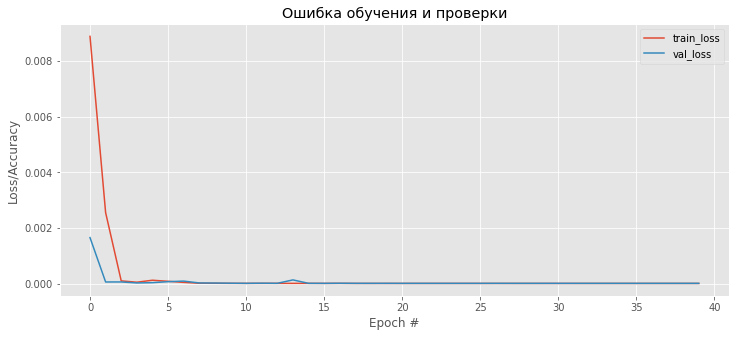

In [ ]:
# строим графики потерь и точности
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure(figsize=(12, 5))
plt.plot(N, results["loss"], label="train_loss")
plt.plot(N, results["val_loss"], label="val_loss")
plt.title("Ошибка обучения и проверки") 
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


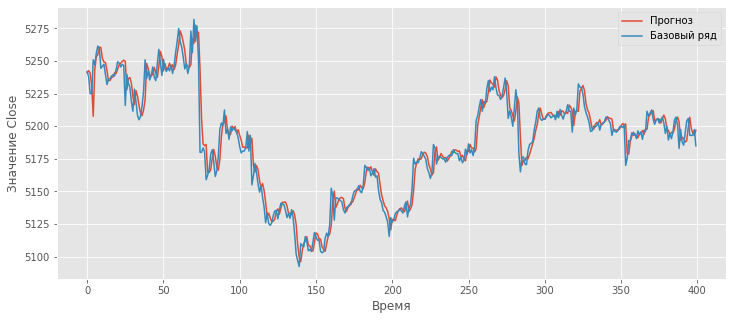

In [ ]:
# Прогнозируем данные текущей сетью
(predVal, yValUnscaled) = get_pred(model_1,x_test,
                                            y_test,
                                            y_scaler) #Прогнозируем данные

# Отображаем графики
show_predict(0, 400, 0, predVal, yValUnscaled)


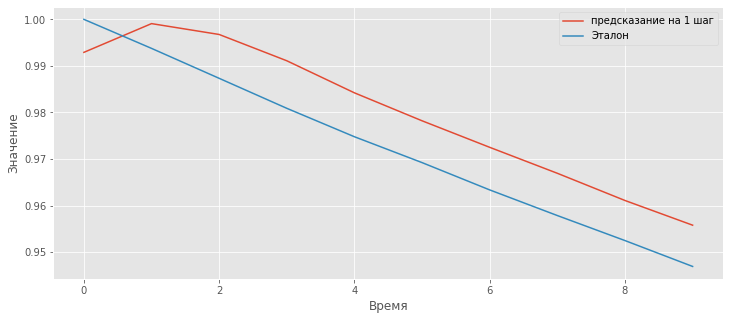

In [ ]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
auto_corr([0], 10, predVal, yValUnscaled)

### Второй бот

In [ ]:
bot = popul[1]
print(bot)

model_2 = create_randnet(bot,
                        inputShape[1],
                        inputShape[2],
                        outputShape[1])
model_2.summary()


[0, 9, 3, 3, 1, 4, 1, 5, 4, 1, 1, 1, 1, 8, 5, 0, 1, 1, 0, 6, 1, 9, 1, 0, 3]
Model: "sequential_422"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_956 (Conv1D)          (None, 300, 512)          8192      
_________________________________________________________________
max_pooling1d_428 (MaxPoolin (None, 75, 512)           0         
_________________________________________________________________
conv1d_957 (Conv1D)          (None, 75, 32)            65568     
_________________________________________________________________
max_pooling1d_429 (MaxPoolin (None, 75, 32)            0         
_________________________________________________________________
conv1d_958 (Conv1D)          (None, 75, 256)           41216     
_________________________________________________________________
flatten_423 (Flatten)        (None, 19200)             0         
__________________________________________

In [ ]:
epoch_list = [(7, Adam(learning_rate=1e-4)),
              (10, Adam(learning_rate=1e-5)),
              (10, Adam(learning_rate=1e-6)),
              (13, Adam(learning_rate=1e-7)),
              ]
epochs = 0
for elem in epoch_list: epochs += elem[0] 

val_loss = []
loss= []
#Комипилируем и обучаем
for epoch_lr, opt in epoch_list:
    model_2.compile(optimizer=opt,
                    loss='mse')
    history = model_2.fit(train_datagen,                             
                        epochs=epoch_lr, 
                        validation_data=val_datagen)
    val_loss.extend(history.history['val_loss'])
    loss.extend(history.history['loss'])
    
results = {'loss':loss, 'val_loss':val_loss}



Epoch 1/7
901/901 [==============================] - 6s 6ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 2/7
901/901 [==============================] - 5s 6ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 3/7
901/901 [==============================] - 5s 6ms/step - loss: 4.0224e-04 - val_loss: 0.0023
Epoch 4/7
901/901 [==============================] - 5s 6ms/step - loss: 1.0803e-04 - val_loss: 1.1033e-04
Epoch 5/7
901/901 [==============================] - 5s 6ms/step - loss: 2.2636e-04 - val_loss: 2.0464e-05
Epoch 6/7
901/901 [==============================] - 5s 6ms/step - loss: 5.6489e-05 - val_loss: 4.2601e-05
Epoch 7/7
901/901 [==============================] - 5s 6ms/step - loss: 7.0743e-05 - val_loss: 1.4915e-04
Epoch 1/10
901/901 [==============================] - 6s 6ms/step - loss: 1.7851e-05 - val_loss: 1.7630e-05
Epoch 2/10
901/901 [==============================] - 6s 6ms/step - loss: 1.1354e-05 - val_loss: 3.1055e-05
Epoch 3/10
901/901 [==============================] - 6

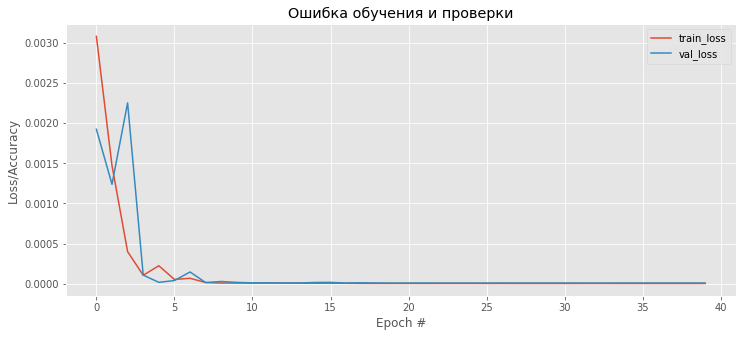

In [ ]:
# строим графики потерь и точности
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure(figsize=(12, 5))
plt.plot(N, results["loss"], label="train_loss")
plt.plot(N, results["val_loss"], label="val_loss")
plt.title("Ошибка обучения и проверки") 
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


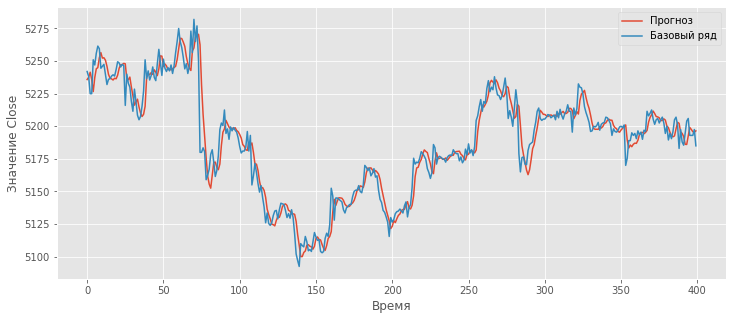

In [ ]:
# Прогнозируем данные текущей сетью
(predVal, yValUnscaled) = get_pred(model_2,x_test,
                                            y_test,
                                            y_scaler) #Прогнозируем данные

# Отображаем графики
show_predict(0, 400, 0, predVal, yValUnscaled)


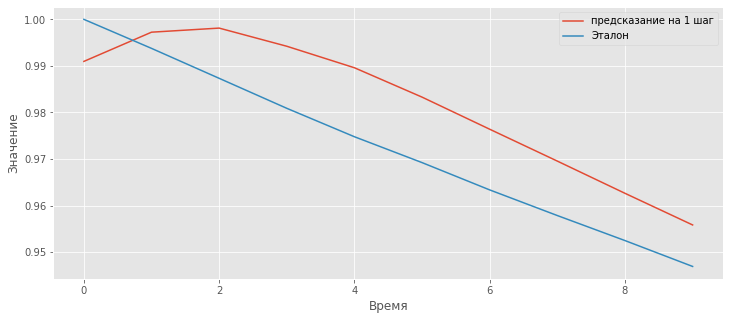

In [ ]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
auto_corr([0], 10, predVal, yValUnscaled)

### Третий бот

In [ ]:
bot = popul[2]
print(bot)

model_3 = create_randnet(bot,
                        inputShape[1],
                        inputShape[2],
                        outputShape[1])
model_3.summary()


[0, 8, 2, 3, 1, 2, 0, 4, 5, 1, 4, 1, 1, 4, 5, 0, 3, 2, 1, 8, 3, 3, 3, 0, 3]
Model: "sequential_432"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_983 (Conv1D)          (None, 300, 256)          2816      
_________________________________________________________________
max_pooling1d_434 (MaxPoolin (None, 150, 256)          0         
_________________________________________________________________
conv1d_984 (Conv1D)          (None, 150, 16)           20496     
_________________________________________________________________
dense_1072 (Dense)           (None, 150, 256)          4352      
_________________________________________________________________
flatten_433 (Flatten)        (None, 38400)             0         
_________________________________________________________________
dense_1073 (Dense)           (None, 8)                 307208    
__________________________________________

In [ ]:
epoch_list = [(7, Adam(learning_rate=1e-4)),
              (10, Adam(learning_rate=1e-5)),
              (10, Adam(learning_rate=1e-6)),
              (13, Adam(learning_rate=1e-7)),
              ]
epochs = 0
for elem in epoch_list: epochs += elem[0] 

val_loss = []
loss= []
#Комипилируем и обучаем
for epoch_lr, opt in epoch_list:
    model_3.compile(optimizer=opt,
                    loss='mse')
    history = model_3.fit(train_datagen,                             
                        epochs=epoch_lr, 
                        validation_data=val_datagen)
    val_loss.extend(history.history['val_loss'])
    loss.extend(history.history['loss'])
    
results = {'loss':loss, 'val_loss':val_loss}



Epoch 1/7
901/901 [==============================] - 5s 5ms/step - loss: 0.0054 - val_loss: 9.2907e-05
Epoch 2/7
901/901 [==============================] - 4s 5ms/step - loss: 1.1902e-04 - val_loss: 8.0750e-05
Epoch 3/7
901/901 [==============================] - 4s 5ms/step - loss: 0.0064 - val_loss: 1.9547e-04
Epoch 4/7
901/901 [==============================] - 4s 5ms/step - loss: 7.7234e-05 - val_loss: 9.8340e-05
Epoch 5/7
901/901 [==============================] - 4s 5ms/step - loss: 6.1897e-05 - val_loss: 1.2645e-04
Epoch 6/7
901/901 [==============================] - 4s 5ms/step - loss: 8.2667e-05 - val_loss: 3.5999e-04
Epoch 7/7
901/901 [==============================] - 4s 5ms/step - loss: 9.2161e-05 - val_loss: 1.4202e-04
Epoch 1/10
901/901 [==============================] - 5s 5ms/step - loss: 4.9434e-05 - val_loss: 2.9032e-05
Epoch 2/10
901/901 [==============================] - 4s 5ms/step - loss: 2.7322e-05 - val_loss: 5.4527e-05
Epoch 3/10
901/901 [=======================

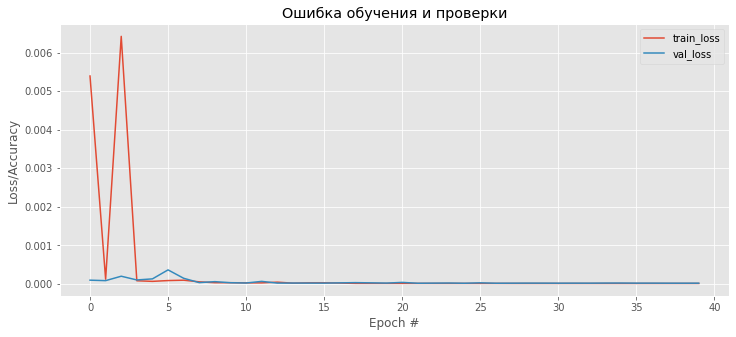

In [ ]:
# строим графики потерь и точности
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure(figsize=(12, 5))
plt.plot(N, results["loss"], label="train_loss")
plt.plot(N, results["val_loss"], label="val_loss")
plt.title("Ошибка обучения и проверки") 
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


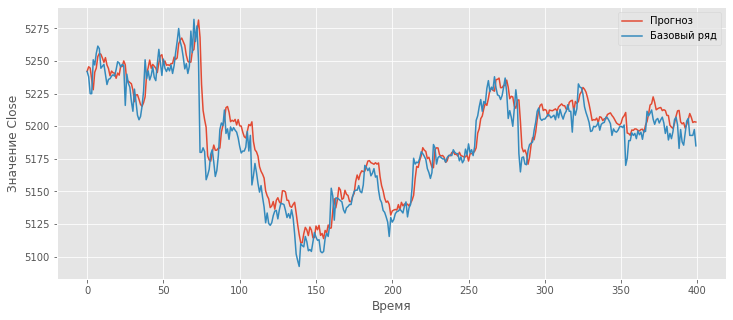

In [ ]:
# Прогнозируем данные текущей сетью
(predVal, yValUnscaled) = get_pred(model_3, x_test,
                                            y_test,
                                            y_scaler) #Прогнозируем данные

# Отображаем графики
show_predict(0, 400, 0, predVal, yValUnscaled)


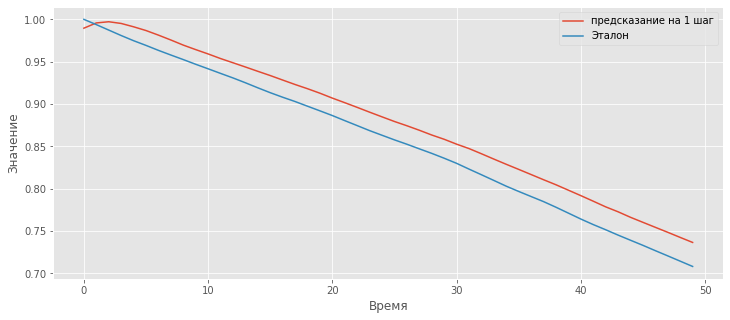

In [ ]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
auto_corr([0], 50, predVal, yValUnscaled)

## Пример "человеческой сборки" линейной сети




In [ ]:
# Упрощенная модель с одномерной сверткой
model_conv_hum = Sequential()
model_conv_hum.add(Conv1D(64, 5, input_shape=x_test.shape[1:], activation='relu'))
model_conv_hum.add(Conv1D(64, 5, activation='relu'))
model_conv_hum.add(MaxPooling1D())
model_conv_hum.add(Flatten())
model_conv_hum.add(Dense(y_test.shape[1], activation='linear'))

epoch_list = [(10, Adam(learning_rate=1e-4)),
              (5, Adam(learning_rate=1e-5)),
              (5, Adam(learning_rate=1e-6)),
              (5, Adam(learning_rate=1e-7)),
              ]
             
epochs = 0
for elem in epoch_list: epochs += elem[0]

val_loss = []
loss= []
#Комипилируем и обучаем
for epoch_lr, opt in epoch_list:
    model_conv_hum.compile(optimizer=opt,
                    loss='mse')
    history = model_conv_hum.fit(train_datagen,                             
                        epochs=epoch_lr, 
                        validation_data=val_datagen)
    val_loss.extend(history.history['val_loss'])
    loss.extend(history.history['loss'])
    
results = {'loss':loss, 'val_loss':val_loss}

Epoch 1/10
901/901 [==============================] - 3s 3ms/step - loss: 0.0015 - val_loss: 3.1959e-04
Epoch 2/10
901/901 [==============================] - 3s 3ms/step - loss: 5.2220e-04 - val_loss: 3.9946e-04
Epoch 3/10
901/901 [==============================] - 3s 3ms/step - loss: 4.2471e-04 - val_loss: 0.0021
Epoch 4/10
901/901 [==============================] - 3s 3ms/step - loss: 4.1274e-04 - val_loss: 2.2645e-04
Epoch 5/10
901/901 [==============================] - 3s 3ms/step - loss: 4.3074e-04 - val_loss: 8.8978e-04
Epoch 6/10
901/901 [==============================] - 3s 3ms/step - loss: 2.8145e-04 - val_loss: 9.2555e-04
Epoch 7/10
901/901 [==============================] - 3s 3ms/step - loss: 3.0876e-04 - val_loss: 2.3576e-04
Epoch 8/10
901/901 [==============================] - 3s 3ms/step - loss: 2.0778e-04 - val_loss: 0.0020
Epoch 9/10
901/901 [==============================] - 3s 3ms/step - loss: 2.9143e-04 - val_loss: 6.1026e-04
Epoch 10/10
901/901 [===================

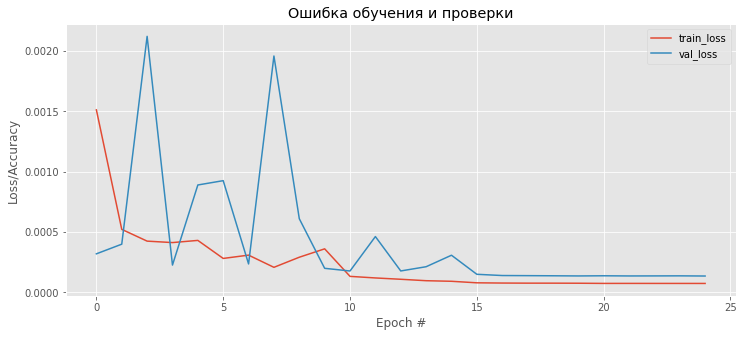

In [ ]:
# строим графики потерь и точности
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure(figsize=(12, 5))
plt.plot(N, results["loss"], label="train_loss")
plt.plot(N, results["val_loss"], label="val_loss")
plt.title("Ошибка обучения и проверки") 
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


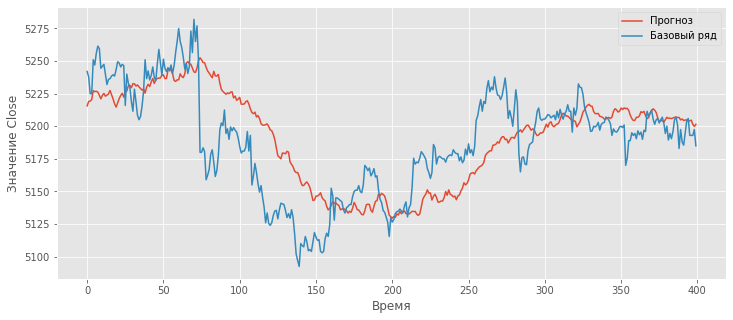

In [ ]:
# Прогнозируем данные текущей сетью
(predVal, yValUnscaled) = get_pred(model_conv_hum,x_test,
                                            y_test,
                                            y_scaler) #Прогнозируем данные

# Отображаем графики
show_predict(0, 400, 0, predVal, yValUnscaled)

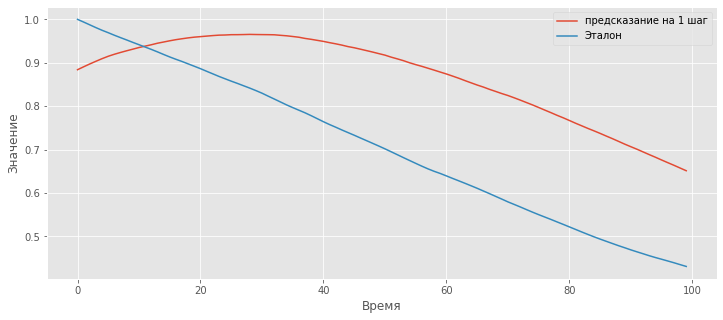

In [ ]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
auto_corr([0], 100, predVal, yValUnscaled)

Подобрать модель с хорошими предсказаниями непросто!!!!

## Проверим предсказания сети на полных данных

Мы ранее для поиска сети использывали разреженные данные(каждые 15 минут)

Давайте обновим набор данных, взяв все и соответсвенно в тест не 3000 отсчетов, 45000

### Полный набор данных

Используем код как выже, но без [::15]

In [ ]:
# Создание общего набора данных из двух датасетов
data = pd.concat([data16_17, data18_19]).to_numpy()

In [ ]:
# Задание текстовых меток каналов данных (столбцов)
CHANNEL_NAMES = ['Open', 'Max', 'Min', 'Close', 'Volume']

# Получение словаря с именами и индексами каналов данных
CHANNEL_INDEX = {name: chan for chan, name in enumerate(CHANNEL_NAMES)}
print(CHANNEL_INDEX)

{'Open': 0, 'Max': 1, 'Min': 2, 'Close': 3, 'Volume': 4}


In [ ]:
# Задание гиперпараметров
CHANNEL_X = CHANNEL_NAMES                 # Отбор каналов входных данных
CHANNEL_Y = ['Close']                     # Отбор каналов данных для предсказания
SEQ_LEN = 300                             # Длина прошедших данных для анализа
BATCH_SIZE = 32                           # Объем батча для генератора
TEST_LEN = 45000                          # Объем тестовой выборки
TRAIN_LEN = data.shape[0] - TEST_LEN      # Объем обучающей выборки

In [ ]:
# Формирование списков индексов каналов данных для входных и выходных выборок
chn_x = [CHANNEL_INDEX[c] for c in CHANNEL_X]
chn_y = [CHANNEL_INDEX[c] for c in CHANNEL_Y]

# Проверка результата
print(chn_x, chn_y)

# Разделение данных на тренировочный и тестовый наборы
# 2*SEQ_LEN - для разрыва между тренировочными и тестовыми данными 
# варьируемый параметр, страховка от пересечения
data_train, data_test = data[:TRAIN_LEN], data[TRAIN_LEN + 2*SEQ_LEN:]

# Отбор входных данных
x_data_train, x_data_test = data_train[:, chn_x], data_test[:, chn_x]

# Масштабирование данных
x_scaler = MinMaxScaler()
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

# Отбор выходных данных
y_data_train, y_data_test = data_train[:, chn_y], data_test[:, chn_y]

# Масштабирование данных
y_scaler = MinMaxScaler()
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)

# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')

# Создание генератора для обучения
train_datagen = TimeseriesGenerator(x_data_train, 
                                    y_data_train,
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)

# Аналогичный генератор для валидации при обучении
val_datagen = TimeseriesGenerator(x_data_test, 
                                  y_data_test,
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

# Проверка формы выдаваемого генератором результата
print(f'Train batch x: {train_datagen[0][0].shape}, y: {train_datagen[0][1].shape}')

[0, 1, 2, 3, 4] [3]
Train data: (436872, 5), (436872, 1)
Test  data: (44400, 5), (44400, 1)
Train batch x: (32, 300, 5), y: (32, 1)


In [ ]:
inputShape = train_datagen[0][0].shape
print(inputShape)
outputShape = train_datagen[0][1].shape
print(outputShape)

(32, 300, 5)
(32, 1)


In [ ]:
# Генератор тестовой выборки, генерирует один батч на всю выборку
test_datagen = TimeseriesGenerator(x_data_test, 
                                   y_data_test,
                                   length=SEQ_LEN,
                                   stride=1,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

# Формирование тестовой выборки из генератора
x_test, y_test = test_datagen[0]

# Проверка формы тестовой выборки
print(f'Test x: {x_test.shape}, y: {y_test.shape}')

Test x: (44100, 300, 5), y: (44100, 1)


## Тестируем 1ю модель

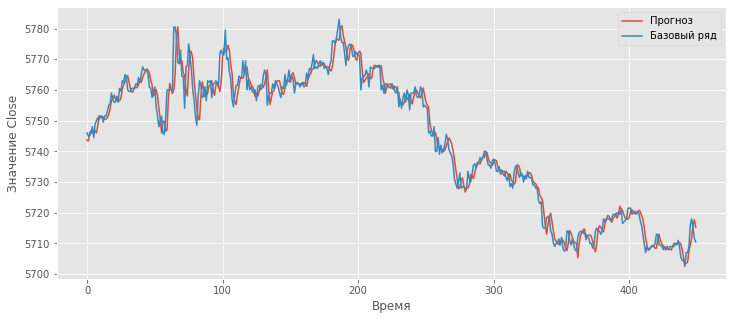

In [ ]:
# Прогнозируем данные текущей сетью
(predVal, yValUnscaled) = get_pred(model_1,x_test,
                                            y_test,
                                            y_scaler) #Прогнозируем данные

# Отображаем графики
show_predict(0, 450, 0, predVal, yValUnscaled)

Оценим модель на точность на полных проверочных данных (без повторного обучения на них)

In [ ]:
model_1.evaluate(x_test,y_test) 

1379/1379 [==============================] - 4s 3ms/step - loss: 8.6852e-07


8.685242960382311e-07

Вполне точные предсказания на 1 шаг уже для полных данных, посмотрим еще ближе

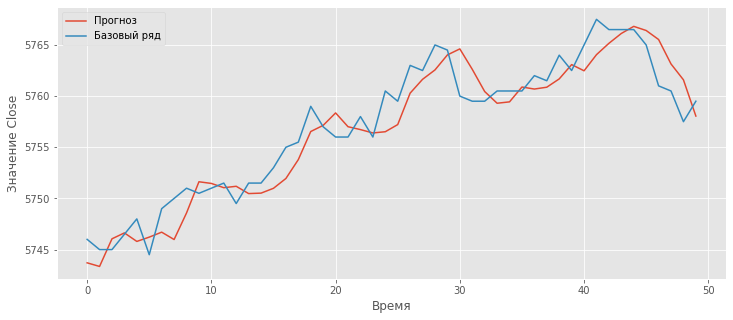

In [ ]:
# Прогнозируем данные текущей сетью
(predVal, yValUnscaled) = get_pred(model_1,x_test,
                                            y_test,
                                            y_scaler) #Прогнозируем данные

# Отображаем графики
show_predict(0, 50, 0, predVal, yValUnscaled)

Так как ранее были разреженные данные (через 15 отсчетов), то из текущих данных уже в 50 полных отсчетов нейронная сеть видела в проверочной выборке только 3-4 отсчета


Искать архитектуру модели можно на разреженных данных и она вполне работоспособна и на полных данных. Степень разреженности зависит от валатильности самих данных.

В нашем случае данные каждые 15 минут вполне подходят для поиска сети

**Содержание темы**

1. Практический ноутбук 1

2. [Практический ноутбук 2](https://colab.research.google.com/drive/1lkuUWExXbKCO7V6Rh40aM5EmPgjdcobe?usp=sharing)